In [1]:
#!/usr/bin/env python3

################################
# Scientific imports
################################
import matplotlib.pyplot as plt
import numpy as np

from astroquery.mast import Observations
from astroquery.mast import Catalogs

from astropy.table import Table
from astropy.table import QTable
from astropy.io import fits
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import aggregate_downsample

import lightkurve as lk

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, gc
from datetime import datetime
import pandas as pd
import seaborn as sb
from collections import Counter

################################
# Suppress Warnings
################################
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

################################
# Initialisers
################################
plt.rcParams["figure.figsize"] = (16,5)
sb.set()

# Load the Data files
fitsarr = np.load("fitslist.npy")

In [2]:
################################
# Functions
################################

def LoadListGeneral(f):
    
    lst=[]
    try:
        # Assuming everything CAN go well, do this
        with open(f"./csv_files/Z_or_O_{f}.zip") as df:
            csvdf = csv.reader(df)
            for lineholder in csvdf:
                line = lineholder[0]                # 'lineholder' is a list, 1 element long, containing only a single string
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    lst.append(line.split()[0])     # Add line to list
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    
    return lst

def TidyCSV(f):
    #csv_file = pd.read_csv(f'./csv_files/Z_or_O_{f}.zip')[1:-1].drop(['sap_flux', 'sap_flux_err', 'sap_flux_norm'], axis=1)
    df = pd.DataFrame(pd.read_csv(f'./csv_files/Z_or_O_{f}.zip')[1:-1].drop(['sap_flux', 'sap_flux_err', 'sap_flux_norm'], axis=1))
    
    mean, median, stddev = sigma_clipped_stats(df['pdcsap_flux'])
    df['pdcsap_flux_norm'] = df['pdcsap_flux'] / median
    
    compression_opts = dict(method="zip", archive_name=f"Z_or_O_{f}.csv")  
    df.to_csv(f"./csv_files/Z_or_O_{f}.zip", index=False, compression=compression_opts)

In [3]:
TICID = np.load("ZeroOrOneExoplanetTICids.npy")

masterlist = [0] * len(TICID)

In [4]:
TICID[0]

5068

In [50]:
for i in TICID:
    TidyCSV(i)

In [46]:
QWERTY = pd.read_csv('./csv_files/Z_or_O_5068.zip')
QWERTY

,time,pdcsap_flux,pdcsap_flux_err,pdcsap_flux_norm
0,0 days 02:14:52.764328536,116796.430,36.730910,1.000295
1,0 days 02:16:52.762477810,117205.800,36.772842,1.003801
2,0 days 02:18:52.760627084,116686.375,36.671310,0.999353
3,0 days 02:20:52.758776358,116946.625,36.704082,1.001581
4,0 days 02:22:52.756925632,116816.450,36.708570,1.000467
...,...,...,...,...
20074,-3 days +02:18:33.324426824,116868.780,36.719925,1.000915
20075,-3 days +02:20:33.318070007,116719.280,36.701084,0.999634
20076,-3 days +02:22:33.311672937,116513.336,36.660007,0.997871
20077,-3 days +02:24:33.305275866,116858.820,36.761040,1.000830


In [53]:
QWERTY['time'].astype('timedelta64[ns]')

ValueError: Could not convert object to NumPy timedelta

In [54]:
ts = TimeSeries.from_pandas(QWERTY)
ts

TypeError: DataFrame does not have a DatetimeIndex

In [7]:
def MakeTimeSeries(f, binSize=0.2, timedBinSize=0.003):
    
    #print("Processing File {} of {}".format(i+1,L))
    
    ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')
    periodogram = BoxLeastSquares.from_timeseries(ts, 'pdcsap_flux')
    results = periodogram.autopower(binSize * u.day)  
    best = np.argmax(results.power)  
    period = results.period[best]
    transit_time = results.transit_time[best]
    ts_folded = ts.fold(period=period, epoch=transit_time)
    mean, median, stddev = sigma_clipped_stats(ts_folded['pdcsap_flux'])
    ts_folded['pdcsap_flux_norm'] = ts_folded['pdcsap_flux'] / median
    
    # Delete unnecessary vars
    del ts, periodogram, period, results, best, transit_time, mean, median, stddev
    
    print("   > Converting to DataFrame")
    dropcols = ['timecorr', 'cadenceno', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'quality',
       'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err',
       'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err',
       'pos_corr1', 'pos_corr2']
    df = pd.DataFrame(ts_folded.to_pandas()[1:-1].drop(dropcols, axis=1))
    df = df.reset_index()
    
    print("   > Done!")
    return(df)

#####################################################################################################################

def MakeFoldedTimeSeries(f, binSize=0.2, timedBinSize=0.003):
    
    #print("Processing File {} of {}".format(i+1,L))
    
    ts = TimeSeries.read(fitsarr[int(f)], format='tess.fits')
    periodogram = BoxLeastSquares.from_timeseries(ts, 'pdcsap_flux')
    results = periodogram.autopower(binSize * u.day)  
    best = np.argmax(results.power)  
    period = results.period[best]
    
    lc = lk.LightCurve(time=range(len(ts)), flux=ts['pdcsap_flux_norm'])
    fold_lc = lc.fold(period=period, normalize_phase=True)
    
    print("   > Done!")
    return(ts[1:-1], period)

In [57]:
df = MakeTimeSeries(TICID[0])
#df = df.reset_index()
df

   > Converting to DataFrame
   > Done!


,time,pdcsap_flux,pdcsap_flux_err,pdcsap_flux_norm
0,0 days 02:14:52.764328536,116796.429688,36.730911,1.000295
1,0 days 02:16:52.762477810,117205.796875,36.772842,1.003801
2,0 days 02:18:52.760627084,116686.375000,36.671310,0.999353
3,0 days 02:20:52.758776358,116946.625000,36.704082,1.001581
4,0 days 02:22:52.756925632,116816.453125,36.708569,1.000467
...,...,...,...,...
20074,-3 days +02:18:33.324426824,116868.781250,36.719925,1.000915
20075,-3 days +02:20:33.318070007,116719.281250,36.701084,0.999634
20076,-3 days +02:22:33.311672937,116513.335938,36.660007,0.997871
20077,-3 days +02:24:33.305275866,116858.820312,36.761040,1.000829


In [8]:
ts,period = MakeFoldedTimeSeries(TICID[0])

dropcols = ['timecorr', 'cadenceno', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'quality',
       'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err',
       'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err',
       'pos_corr1', 'pos_corr2']
ts.remove_columns(dropcols)
mean, median, stddev = sigma_clipped_stats(ts['pdcsap_flux'])
ts['pdcsap_flux_norm'] = ts['pdcsap_flux'] / median
ts

   > Done!


time,pdcsap_flux,pdcsap_flux_err,pdcsap_flux_norm
,electron / s,electron / s,
object,float32,float32,float32
2018-07-11T01:22:36.268,1.1679643e+05,3.6730911e+01,1.0002950e+00
2018-07-11T01:24:36.267,1.1720580e+05,3.6772842e+01,1.0038011e+00
2018-07-11T01:26:36.265,1.1668638e+05,3.6671310e+01,9.9935251e-01
2018-07-11T01:28:36.263,1.1694662e+05,3.6704082e+01,1.0015814e+00
2018-07-11T01:30:36.261,1.1681645e+05,3.6708569e+01,1.0004666e+00
2018-07-11T01:32:36.259,1.1698708e+05,3.6750797e+01,1.0019279e+00
...,...,...,...
2018-08-08T07:03:19.140,1.1646191e+05,3.6687435e+01,9.9743015e-01


In [16]:
lc = lk.LightCurve(time=range(len(ts)), flux=ts['pdcsap_flux_norm'])

fold_lc = lc.fold(period=period, normalize_phase=True)
fold_lc

time,flux,flux_err,time_original
,,,
float64,float32,float64,object
-0.4999647829075171,9.9680215e-01,nan,14926.0
-0.49992848365193,9.9760866e-01,nan,16113.0
-0.4998921843963428,1.0001611e+00,nan,17300.0
-0.4998558851407557,1.0023500e+00,nan,18487.0
-0.4998195858851685,9.9821132e-01,nan,19674.0
-0.4995633267699473,1.0005928e+00,nan,505.0
...,...,...,...
0.49978112230350513,1.0005685e+00,nan,6617.0


<AxesSubplot:xlabel='Phase', ylabel='Flux'>

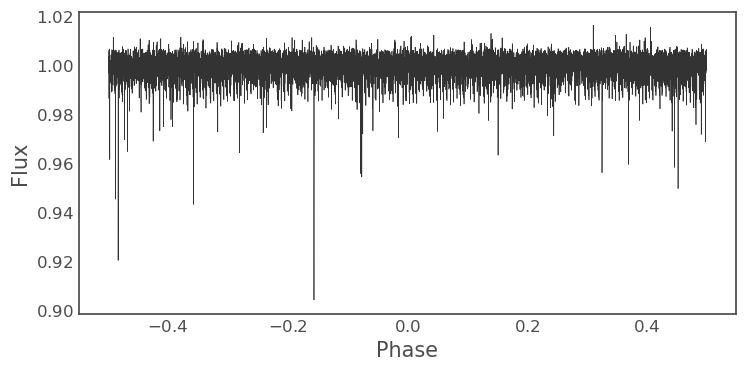

In [18]:
fold_lc.plot()

In [43]:
fold_lc.items['flux']

TypeError: 'method' object is not subscriptable